Last article, I gave my basic reasons for pursuing a research project into the changing demographics of the slave trade in the Americas. This was very broad, and very vague. However, now I am about to plunge into locating the necessary data to reconstruct the history I wish to reconstruct. And already I am running into technical issues. 

The archive I want to use was created 22 years ago, back when Microsoft was the preeminent provider of consumer computer products. Everything is saved as a .dbf database file, with .sav, .sps and other files used to port it to an SPSS application. I had never heard of SPSS before this project. It's a proprietary system currently owned by IBM and used heavily in the GIS community. Opening this type of layered database file in a modern environment is complicated. Microsoft has a deprecated product, Visual FoxPro, and of course there are paid products. However, I want to use a modern Jupyter notebook with Python, pandas and other standard data science tools.

I turned to the great oracle, Google, to find out how to open a .dbf file in Jupyter. There is a fairly well known package, PySal, that seemed ideal. Unfortunately, I am using Python 3.8. Pysal is dependent on a package called Rasterio, which in turn is dependent on a set of C libraries called GDAL. And here is where I ran into issues. GDAL does not, for some reason, edit its path environment variables on a Windows machine with Python 3.8. There are open issues with several development teams, but all are quite recent (the past year or so) and the issue is not yet fixed. While I'd love to use a Linux machine, at the moment I'm stuck with Windows.

So I am going to have to sacrifice the convenience of Pysal and turn to a more hacked together solution. Python comes with a dbfread library. It is going to take some work to get dbfread into Pandas, but hopefully not too much.

In [1]:
import pandas as pd
from dbfread import DBF

# Need this later on for data cleaning
import numpy as np
import datetime

# Chart visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Nearest Neighbor Algorithm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import statistics

Above, I imported Pandas. Pandas is perhaps the most popular data science package for Python and is extremely useful. I've used some of its competitors, especially Turi, and Pandas is both better documented and more supported. It does have some strange quirks, such as its odd use of zero indexing, but overall is a fun package to use.

Notice I'm also using dbfread. I'm using a script form the documentation at https://dbfread.readthedocs.io/en/latest/exporting_data.html. Please be nice to me processor gods, I just want a dataframe.

In [2]:
dbf = DBF('SLAVE.DBF')

Let's try to convert the .dbf database into a Pandas dataframe. I'm going to use Pandass' inbuilt DataFrame function because it will continue to be updated with Pandas' development. It is important to note that dbfread is only a somewhat maintained library. After parsing the source code, I noticed a lot of development is still needed. This would come back to bite me as I worked with this project. Per dbfread's documentation, we also need to pass an iterable form of the dbf file we created above. Below is the single line of code that nearly destroyed my sanity.

In [30]:
df = pd.DataFrame(iter(dbf))

Originally, this errored. And it errored in the most bizarre way. It was throwing errors about float numbers and integers with full stops. I was very confused and google didn't help much. In fact, most people just ended up editing their data file. I do not have the ability to open a dbf file, nor did I really want to open a file, edit it however many times, and close it again. So, I opened the source code of dbfread to the line that triggered the exception. Below I have a copy of the exception, lovingly recreated for you after I fixed it. Notice all the nonsense about integers and floats and b'.'.

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
c:\users\casti\appdata\local\programs\python\python38\lib\site-packages\dbfread\field_parser.py in parseN(self, field, data)
    179         try:
--> 180             return int(data)
    181         except ValueError:

ValueError: invalid literal for int() with base 10: b'.'

***Edited for clarity***

c:\users\casti\appdata\local\programs\python\python38\lib\site-packages\dbfread\field_parser.py in parseN(self, field, data)
    184             else:
    185                 # Account for , in numeric fields
--> 186                 return float(data.replace(b',',b'.'))
    187                 '''
    188                 if isinstance(data, float) or len(data) >= 2:

ValueError: could not convert string to float: b'.'

As I said, googling this error only turned up more people with the same issue. Since I couldn't use the package that everyone else seemed to prefer (PySal!) I decided to wade into the source code. Perhaps somewhere in the field_parser.py file I'd find a clue to fixing my code.

I didn't. Instead, I found the reason the code errored in the first place. Here's some code taken directly from the fieldParser.py file in the dbfread package.

    def parseN(self, field, data):
        """
        Parse numeric field (N)

        Returns int, float or None if the field is empty.
        """
        
        # In some files * is used for padding.
        data = data.strip().strip(b'*')
        try:
            return int(data)
        except ValueError:
            if not data.strip():
                return None
            else:
                # Account for , in numeric fields
                return float(data.replace(b',',b'.'))
                
Folks, that was the entirety of the exception handling. The default case was, simply, to replace all commas with full stops and then try to convert whatever monstrosity resulted into a float. It is understandable Python didn't really want to do this. By this logic, if the number 1,234.56 was passed to the parseN method, the result would be 1.234.56. This is, obviously, neither a float nor an integer. It is an unholy creation of man. I decided to fix this.

First, I decided the final case should be the float NaN. NaN stands for, in the surreally linear logic of computer scientists, *N*ot *A* *N*umber. Get it? NaN...Not A Number. This meant that, if the code was absolutely sure we were dealing with numbers, but it kept mangling whatever it was passed, it should just insert the Pythonic equivalent of a shrug. This is probably not the best design, but short of refactoring the whole dbfreads library I thought it would work as a stopgap. The code now read:

    def parseN(self, field, data):
        """
        Parse numeric field (N)

        Returns int, float or None if the field is empty.
        """
        
        # In some files * is used for padding.
        
        data = data.strip().strip(b'*')
        try:
            return int(data)
        except ValueError:
            if not data.strip():
                return None
            else:
                # Account for , in numeric fields
                if isinstance(data, float):
                    return float(data.replace(b',', b'.')
                return float(b"NaN")
                
I don't actually know why the function needs to return a binary code. Perhaps there's a calling function somewhere in dbfreads that only accepts binary. Maybe it's a powermove on the part of the developers, who wanted to remind the computer it only speaks binary. Nonetheless, I am now returning the binary version of the float number "NaN".

This didn't quite fix my problem. Instead, I still kept getting that error about the binary full stop from earlier. It had moved on a few lines (I was inserting counters at one point to trace where in the file there were errors) but I was still having problems with this function. So I started thinking about when a number might *look* like a float but was, in fact, never meant to be such a thing. Suppose there was a field that said *0,*. This would obviously be corruption or entry error, but hey data is messy. If you called this parseN function on *0,*, it wouldn't convert to an integer, it *would* raise an exception, but would not trigger the replace method. Instead, it would turn into a float "NaN". I didn't want that data loss, even if I don't understand the data. So, I should really build a trap for such pieces of data.


    def parseN(self, field, data):
        """
        Parse numeric field (N)

        Returns int, float or None if the field is empty.
        """
        
        # In some files * is used for padding.
        data = data.strip().strip(b'*')

        try:
            return int(data)
        except ValueError:
            if not data.strip():
                return None
            else:
                # Account for , in numeric fields

                if len(data) >= 2:
                    return float(data.replace(b',',b'.'))
                return float(b'NaN')
                
See my clever little trap? I'm checking to see if the length of the data is over 2. Why? Well, I've already checked if the number is a float. If the data was *0,0* it would already be caught. But the number *1,500.0* still won't be caught. I don't want numbers that are only 1 digit long. They will easily convert to integers, unless the program is trying to pass *','* or some other crazy character as a number. I don't know enought about the program to dig through why it is trying to pass those characters, so I weed them out with the length check. Now, *1,500.0* will get the floating point conversion treatment it deserves.

I also had to make one other little edit. There was a similar problem with a datetime method. However, in this case it looks like the originaly developer forgot to add a .strip() method they clearly meant to. This is because, in the comments, they clearly indicate they intend on testing for both empty spaces *and* spaces full of zeros for a datetime column. Nonetheless, they only strip off the zeros, not the spaces. I added a clause looking for the empty spaces and now it works.

This is the end of the post. There's still a lot of work to do to make this data accessible and accurate enough for any sort of valid historical conclusions to be drawn. However, it is now loaded, the dbfread source code has been strengthened, and it's time to take a break. Somewhere, distantly, I hear a martini glass clinking.

OK, picking up where I left off. It's time to clean this data! To see what I mean, observe the following code:

In [31]:
df.dtypes

    

DOCDATE        object
YEAR            int64
DOCNO          object
NOTARY         object
CODER         float64
               ...   
ARRIVEDATE     object
FROM           object
UNBAPT        float64
VIA           float64
COMMENTS       object
Length: 114, dtype: object

While there are 114 columns to be concerned about, we need to start at the very beginning. The column DOCDATE should be a datetime object, but notice that Pandas currently only knows that this column is an object. The object dtype indicates some form of string, or a mixed type column. This tricky little clause means we are uncertain if all but one DOCDATE entries is a proper datetime object, and one is broken, or if there is a scattering of non-datetime objects.

In [32]:
df['DOCDATE'] = pd.to_datetime(df['DOCDATE'])
df['DOCDATE'].dtype

dtype('<M8[ns]')

In [33]:
df.dtypes

DOCDATE       datetime64[ns]
YEAR                   int64
DOCNO                 object
NOTARY                object
CODER                float64
                   ...      
ARRIVEDATE            object
FROM                  object
UNBAPT               float64
VIA                  float64
COMMENTS              object
Length: 114, dtype: object

Surprisingly, I was able to simply convert the DOCDATE column directly to the datetime object in Python. This indicates the DOCDATE column was, in fact, full of dates and not something else. We can continue on like this for all 114 columns. 

I'm about to do something a bit controversial. Essentially, I'm converting my YEAR column, but to an integer and not a date. My reason for this is pretty simple. I don't actually want to use the year column AS a date. Dates are for things like machine output and other artifacts from the Information Age. I'm interested in a simple number, namely the number of years in the Common Era. I may have to manipulate this data in ways that is more useful as an integer, such as finding how many years elapsed between a slaves sale and resale, etc. While there are probably functions for all of this work, for the sake of clarity I'm converting YEAR into an integer and not a date.

In [34]:
df['YEAR'].astype('int')

0         1719
1         1719
2         1719
3         1719
4         1719
          ... 
100661    1820
100662    1820
100663    1820
100664    1820
100665    1820
Name: YEAR, Length: 100666, dtype: int32

As fun as it might be to continually change each of these fields by hand, I'm the lazy sort of data analyst who believes computers were invented so I could lounge in the pool. It's time to put some good old Python into use. I know there are 114 columns. I know that I want *most* of those columns to be strings. This is because there is a lot of data that is best understood as text. Columns like NOTARY and FROM are clearly meant to be a personal name and a placename. However, there are a few that should *NOT* be strings. The column ARRIVEDATE, for instance, should always be a datetime. 
Other columns should be mostly an integer or float, except for some sort of value indicating an unknown status. The column AGE, for instance, should never be a string unless the answer is 'UNKNOWN'. While the practice of owning humans as chattel was dehumanizing in the extreme, the resale of humans did create a need for strict record keeping. Most slave ages would be known to a relatively sure degree, if they were born on a plantation. A slave newly trafficked, or perhaps resold from a more chaotic or fraudulent area, would have an unknown age. So what I need to do now is find all of the columns that *look* like they should be non-strings. If their current pandas dtype is 'object', this indicates mixed types such as a number and a string, a float and an int, or some other form of mixed up data.
So, first, I need to identify which columns have mixed types. Below I wrote some code to iterate over the dataframe, select all of the object dtypes, and return a list. I know in introductory programming courses I hated the section on list comprehensions, because they seemed to be confusing, but in a Jupyter notebook like this it really is quite handy to have all of the code on a single line.

In [35]:
object_col = [col for col in df.columns if df[col].dtype == 'object']

Now that I know precisely what columns have an object dtype, I need to inspect the list manually. I don't know of an automatic way to figure out what columns shouldn't have strings. Perhaps when the singularity comes, this will be a side effect. Of course, it doesn't seem like Skynet or whatever Facebook means by Meta will care much for human history.

So, should the Singularity come, I'm putting in my bid as Advisor to the Singularity on History. In the meantime, I'm going to try to continue rehumanizing people who were dehumanized. And fighting the good fight against corrupt data. And drink as many ciders as possible.

To return to the point, let's see what columns might potentially need our attention.

In [36]:
object_col

['DOCNO',
 'NOTARY',
 'DATEINV',
 'DATESALE',
 'PARISH',
 'ESTATE_OF',
 'FIRSTNAME',
 'ESTATE',
 'SELLER',
 'FIRST1',
 'BUYER',
 'FIRST2',
 'NAMEXPLAIN',
 'NAME',
 'SKILLS',
 'CHARACTER',
 'SICK',
 'SPELL',
 'GROUPMEMB',
 'INVCUR',
 'SALECUR',
 'FAMILY',
 'SPNATMOM',
 'MATENAME',
 'SPELNAMATE',
 'SPNADAD',
 'SPNAGM',
 'SPNAGRPA',
 'CAPTAIN',
 'SHIP',
 'ARRIVEDATE',
 'FROM',
 'COMMENTS']

From this list, I have identified only a few columns that clearly require an integer, float or date. 'DOCNO' is, I'm fairly certain, going to be a numeric code for the documents. It is also possible it is an alphanumeric code, but given the small(ish) number of documents and age of the project I suspect it is numeric. However, ARRIVEDATE, AGE, DATESALE and DATEINV all seem like they should not be strings. There are a few columns that I'm just not sure about. What is SALECUR? Or INVCUR? Since I don't know, I'll have to inspect the columns manually after I'm done this work. But for now, it is import to get as many columns as possible finished.
Below I will make a list of columns I don't think are strings. I will call this, creatively, not_strings. I can add to it later using list methods, and delete if I'm mistaken. I am also using a list comprehension to pull out the not_strings entries from the object_col list. I will call this new list, again creatively, strings.

In [37]:
not_strings = ['DOCNO',
               'ARRIVEDATE',
               'AGE',
               'DATESALE',
               'DATEINV',
               'CODER',
               'DEPOT',
               'LOCATION',
               'DOCTYPE',
               'MAROON',
               'REVOLTS',
               'LANGUAGE',
               'AFLANG',
               'LINGUISTIC',
               'FREE',
               'ESTFREE',
               'ESTATEPOP',
               'WENT',
               'NAMETYPE',
               'SEX',
               'RACE',
               'AGE',
               'AGECATN',
               'SKILLCAT',
               'EXPERT',
               'APPRENTICE',
               'ALITTLE',
               'SKILL2',
               'SKILL3',
               'SKILL4',
               'SKILL5',
               'CHARCAT',
               'CHARCAT2',
               'CHARCAT3',
               'SICKCAT',
               'SICK2',
               'SICK3',
               'SICK4',
               'BIRTHPL',
               'BRUT',
               'GROUP',
               'INVVALUE',
               'INVVALP',
               'SALEVALUE',
               'SALEVALP',
               'FAMILY_Y_N',
               'CHILDREN',
               'MALE',
               'FEMALE',
               'UNDER5',
               'PREGNANT',
               'MOTHER',
               'AGEMOM',
               'RACEMOM',
               'INVWMOM',
               'SOLDWMOM',
               'ORMOM',
               'MATE',
               'AGEMATE',
               'AGECATMATE',
               'RACEMATE',
               'ORIGINMATE',
               'FATHER',
               'AGEDAD',
               'RACEDAD',
               'ORDAD',
               'GRANDCHILD',
               'GRANDSONS',
               'GDAUGHTERS',
               'GRANDMA',
               'AGEGRANDMA',
               'ORGRANDMA',
               'GRANPA',
               'AGEGRANDPA',
               'ORGRANDPA',
               'EMANCIP',
               'DEAD',
               'RUNAWAY',
               'ENTERPRISE',
               'STPORT',
               'VIA'
              ]

strings = [entry for entry in df if entry not in not_strings ]
dates = ['DOCDATE','ARRIVEDATE','DATESALE','DATEINV']
integers = [entries for entries in not_strings if entries not in dates]

Now that I have all of these lists floating around, it is time to actually convert things to strings. It took me awhile to figure out the current method to do this. Pandas was created as a numerical and scientific computing library. It is only recently that a better string dtype has been added. Using methods that seem obvious (to_string()) does not change the dtype. Instead, you need to use a very specific set of formats. Scouring the internet, again, is not very helpful, to the tune of, "The documentation is your best source, look at it here" https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html. Although the string datatype was first implemented in Pandas 1.0.0, there are StackOverflow posts listing incorrect methods for this conversion. ONLY use the ones in the documentation.

In [38]:
def cols_to_correct_type(list_col, type_col):
    '''
    Takes a list of columns that should be converted to a given type and converts them all.
    '''
    for entries in list_col: #iterate over my list of strings, not the entire Dataframe
        df[entries] = df[entries].astype(type_col)  


cols_to_correct_type(strings, 'string')



In [39]:
integers[0]


'DOCNO'

In [40]:
integers = integers[1:]

In [41]:
pd.get_option("mode.use_inf_as_na")
pd.set_option("mode.use_inf_as_na", True)

for col in integers:

    df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)

cols_to_correct_type(integers, 'float')

In [42]:
for col in integers:
    if df[col].dtype != 'float64':
        print(df[col].dtype)

In [43]:
for col in integers:
    df[col] = df[col].fillna(int(-1))
cols_to_correct_type(integers, 'int')

In [44]:
for col in strings:
    df[col] = df[col].fillna('UNKNOWN')
    

In [45]:
for col in strings:
    offenders = []
    if df[col].isin(['']).any():
        offenders.append(col)
print(offenders)


['COMMENTS']


In [46]:
df = df.drop(columns=['COMMENTS'])

In [47]:
dates

['DOCDATE', 'ARRIVEDATE', 'DATESALE', 'DATEINV']

In [48]:
# Test to make sure I've successfully added strings
df.dtypes

DOCDATE       string
YEAR          string
DOCNO         object
NOTARY        string
CODER          int32
               ...  
SHIP          string
ARRIVEDATE    object
FROM          string
UNBAPT        string
VIA            int32
Length: 113, dtype: object

As you can see, I have successfully changed the vast majority of the columns to strings. However, I'm not done yet. What about those five columns with mixed types?

In [49]:
dates

['DOCDATE', 'ARRIVEDATE', 'DATESALE', 'DATEINV']

Yeah, those. Let's fix those up. I suspect DOCNO should be a set of integers, but I'm not sure.

In [50]:
df['DOCNO']

0               
1               
2               
3               
4               
           ...  
100661      3754
100662       223
100663       224
100664       363
100665       363
Name: DOCNO, Length: 100666, dtype: object

In [51]:
df['DOCNO'] = df['DOCNO'].fillna('-1')

In [52]:
df['DOCNO'].isna().any()

False

In [53]:
df['DOCNO']

0               
1               
2               
3               
4               
           ...  
100661      3754
100662       223
100663       224
100664       363
100665       363
Name: DOCNO, Length: 100666, dtype: object

In [56]:
df['DOCNO'] = df['DOCNO'].replace(''.strip(),-1,regex=True)

In [29]:
df['DOCNO']

0           
1           
2           
3           
4           
          ..
100661    -1
100662    -1
100663    -1
100664    -1
100665    -1
Name: DOCNO, Length: 100666, dtype: object

Looks pretty integery to me. Let's try to convert.

In [57]:
df['DOCNO'] = df['DOCNO'].astype('int')

ValueError: invalid literal for int() with base 10: 'fol.89'

Ooooh hooo hooo. An error. What might this beastie be?

ValueError: invalid literal for int() with base 10: ''

Looks like there are some emtpy spaces and/or someone left a blank in the column. Luckily, this is Pandas. It was made for precisely this moment. I could, theoretically, write a for loop that would replace *''* with, well, anything I want. However, all I really need is to call Pandas' function *replace* and someone much better at optimization will take care of the matter for me.

First, I want Pandas to recognize empty spaces as a missing value. Basically, Pandas would really prefer that everything was just numbers. The library was created by some mad scientists, after all, and was never intended for historical research. It doesn't like to recognize things like *None* or a blank space as a missing value. But history is full of messy people doing messy things, so we have to allow as many types of missing values as possible.

In [19]:
pd.get_option("mode.use_inf_as_na")
pd.set_option("mode.use_inf_as_na", True)

OK, after some random sampling, it seems like df['DOCNO'] is full of strings that look like numbers to the human eye. Consider the very last such entry: df['DOCNO'][100665].

In [20]:
df['DOCNO'][100665]

'   363'

I want to remove ALL leading spaces. 

In [21]:
df['DOCNO'][100665].strip()

'363'

But not just for that one entry. I want to do it for the entire column. There is, however, a slight problem. Observe this:

In [22]:
df['DOCNO'][1]

''

I want to use the Pandas' replace function to insert NaN into every empty space. The reason for this is quite simple. An empty space may or may not be interpreted as a missing value, but NaN will ALWAYS be interpreted as a missing value.

In [28]:
df['DOCNO'] = df['DOCNO'].replace('',np.NaN)

Pandas provides a method to check if I have empty values, as specified by NaN. It is the .isna() method.

In [29]:
df['DOCNO'].isna()

0          True
1          True
2          True
3          True
4          True
          ...  
100661    False
100662    False
100663    False
100664    False
100665    False
Name: DOCNO, Length: 100666, dtype: bool

OK, now I know that Pandas recognizes my missing values as missing values. What next? Well, let's try converting the DOCNO column to a float. NaN is technically a float value, and while Pandas provides an int64 type that will allow me to use NaN, I'd rather just convert to a float for now. The Pandas methods should also strip all of those leading blank spaces away. Hopefully. If the processor gods are merciful.

In [30]:
df['DOCNO'] = df['DOCNO'].astype('float')

ValueError: could not convert string to float: 'fol.89'

And...it errored. Why? Well, here is the error.

ValueError: could not convert string to float: 'fol.89'

This seems to say that I have a string in the column that I didn't know about. Unfortunately, I've already half converted the column to floats, so using string methods doesn't work too well. I'm going to have to sort through the column, look at the type of the individual row, and then find what columns contain anything with 'fol' in it.

In [58]:
def mixed_type_search(offending_phrase, col):
    '''
    Takes a string, the offending phrase, and searches for it in an entire column.
    
    Returns a list of all variations containing that phrase.
    '''
    # list of offending phrases
    list_of_offense = []
    
    for elements in df[col]:       
        try:
            # We can only look at elements that are strings.
            if type(elements) == str and offending_phrase in elements and elements not in list_of_offense:
                list_of_offense.append(elements)
                
        except Exception as e:
            try:
                # This might go wrong. It shouldn't lead to an infinite loop, because the 
                # string conversion should make the offending value fail the test next go 
                # around.
                
                if type(elements) != str:
                    mixed_type_search(str(elements),col)
                    
            except:
                print("The offending phrase cannot be found due to type incompatibility")
                return False
    return list_of_offense

print(mixed_type_search('fol','DOCNO'))
                

['fol.89']


Based on these results, it seems like there is only one fol (folder? folio? who cares?). It should be replaced with just simply the number 89, provided the number 89 doesn't already exist in the column. We should check that to make sure we aren't going to merge data that should be distinct.

In [78]:
def does_value_already_exist(value, col, sub_value=None):
    '''
    Takes a value and returns whether the column specified in col already contains
    that value. Used to maintain unique data, such as in DOCNO.
    
    Value is used for longer strings such as 'fol.89'. But I want to check
    whether 89 is in the file, but excluding fol.89.
    '''
    str(value)
    str(col)
    
    # sub_value is optional so the method can be used with just one string
    if value in df[col] and sub_value == None:
        return True
    
    # exclusion logic
    elif value not in df[col] and sub_value != None:
        if sub_value in df[col] :
            return True
    return "Value is not in column already"

print(does_value_already_exist('fol.89', 'DOCNO','89'))


Value is not in column already


Based on the results of the method above, I'd say we're ok replacing fol.89 with 89.

In [60]:
df['DOCNO'] = df['DOCNO'].replace('fol.89',89)

In [61]:
print(mixed_type_search('fol','DOCNO'))

[]


Let's go back to our original goal of converting all of DOCNO to a float.

In [62]:
df['DOCNO'] = df['DOCNO'].astype('int')

ValueError: invalid literal for int() with base 10: 'VIII'

Good heavens, another error.

ValueError: could not convert string to float: 'VIII'

This one, again, should be easy to fix. That's just the roman numeral 8. However, we need to check if doc 8 is already used.

In [79]:
does_value_already_exist('8', 'DOCNO')  # No need for optional parameter, as I 
                                        # only care if 8 exists as a document 
                                        # number

'Value is not in column already'

OK, I consider that clearance to just replace VIII with 8.

In [80]:
df['DOCNO']= df['DOCNO'].replace('VIII',8)

Time to try a float conversion again.

In [81]:
df['DOCNO'] = df['DOCNO'].astype('int')

And more errors. Honestly, it seems like this column could have been left a string. However, I also think imposing an obvious numbering system on the DOCNO column is important later on. Here's the error.

ValueError: could not convert string to float: 'p.252'

Let's see if it's around.

In [38]:
does_value_already_exist(252, 'DOCNO') 

True

Well, that isn't good. There's already a document 252. Plus, that error message looks like a page number.

In [65]:
def search_for_string_in_column_entry(string, col):
    '''
    Takes a string and searches the given dataframe column for the string in a 
    cell of data. Then, returns a list of every location where string occurs.
    '''
    
    return [[index, value] for index, value in df[col].items() if str(string) in str(value)]


print(search_for_string_in_column_entry('p.','DOCNO'))


[[47281, 'p.252'], [47282, 'p.252'], [47283, 'p.252'], [47284, 'p.252'], [47619, 'p. 1'], [47620, 'p. 1'], [47621, 'p. 1'], [47622, 'p. 1'], [47623, 'p. 1'], [49165, 'p. 142'], [49357, 'p. 222'], [49358, 'p. 222'], [49359, 'p. 222'], [49360, 'p. 222'], [49361, 'p. 222'], [49362, 'p. 222'], [49363, 'p. 222'], [49364, 'p. 222'], [51120, 'p. 131'], [51121, 'p. 131'], [51122, 'p. 131'], [51123, 'p. 131'], [51124, 'p. 131'], [51125, 'p. 131'], [51126, 'p. 131'], [56819, 'p. 242']]


Based on these results, we can conclude that someone entered p.252 four times. But why? This seems increasingly like a page number. Is there more to the story? Maybe we should take a close look at each result.

In [75]:
# page_numbers = search_for_string_in_column_entry('.','DOCNO')
for entries in page_numbers:
    print("NOTARY",df['NOTARY'].iloc[entries[0]],df['DOCNO'].iloc[entries[0]])


NOTARY Sp. W. Fla Vol. XI p.252 -1
NOTARY Sp. W. Fla Vol. XI p.252 -1
NOTARY Sp. W. Fla Vol. XI p.252 -1
NOTARY Sp. W. Fla Vol. XI p.252 -1
NOTARY SPWFLA Vol. 14 p. 1 -1
NOTARY SPWFLA Vol. 14 p. 1 -1
NOTARY SPWFLA Vol. 14 p. 1 -1
NOTARY SPWFLA Vol. 14 p. 1 -1
NOTARY SPWFLA Vol. 14 p. 1 -1
NOTARY West Fla Papers XII p. 142 -1
NOTARY Sp. W. Fla Vol. XII p. 222 -1
NOTARY Sp. W. Fla Vol. XII p. 222 -1
NOTARY Sp. W. Fla Vol. XII p. 222 -1
NOTARY Sp. W. Fla Vol. XII p. 222 -1
NOTARY Sp. W. Fla Vol. XII p. 222 -1
NOTARY Sp. W. Fla Vol. XII p. 222 -1
NOTARY Sp. W. Fla Vol. XII p. 222 -1
NOTARY Sp. W. Fla Vol. XII p. 222 -1
NOTARY Sp. W. Fla Vol. XIII p. 131 -1
NOTARY Sp. W. Fla Vol. XIII p. 131 -1
NOTARY Sp. W. Fla Vol. XIII p. 131 -1
NOTARY Sp. W. Fla Vol. XIII p. 131 -1
NOTARY Sp. W. Fla Vol. XIII p. 131 -1
NOTARY Sp. W. Fla Vol. XIII p. 131 -1
NOTARY Sp. W. Fla Vol. XIII p. 131 -1
NOTARY Sp. W. Fla Vol. XII p. 242 -1


I suspect the DOCNO column, in these few cases, is meant to be a supplement to the Notary column. While I'm not sure what Sp. W. Fla Vol. XI precisely refers to (I'll have to dig into the older project's notes and source documents), it seems like the sort of thing that points to a book, which would incidentally have pages. So I'm going to transfer the DOCNO information to the Notary column.

First, create a variable to store the indices AND values we want transferred.

In [73]:
need_transfer_index_values = search_for_string_in_column_entry('.','DOCNO')
need_transfer_index_only = [index for index, values in need_transfer_index_values]

Now transfer the values in need_transfer over to the column 'NOTARY' and insert a -1 in column 'DOCNO'.

In [42]:
df['NOTARY'].iloc[47281]

'Sp. W. Fla Vol. XI'

In [74]:
def transfer_and_replace_col(new_col, old_col, new_value, indices):
    '''
    Transfers the values in old_col into new_col, replacing old_col with the new_value.
    '''
    for index in indices:
        df[new_col].iloc[index] = df[new_col].loc[index] + ' ' + df[old_col].loc[index]
        df[old_col].loc[index] = new_value
        

transfer_and_replace_col('NOTARY', 'DOCNO', -1, need_transfer_index_only)

c:\users\casti\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [44]:
df['NOTARY'].loc[need_transfer_index_only]

47281       Sp. W. Fla Vol. XI p.252
47282       Sp. W. Fla Vol. XI p.252
47283       Sp. W. Fla Vol. XI p.252
47284       Sp. W. Fla Vol. XI p.252
47619            SPWFLA Vol. 14 p. 1
47620            SPWFLA Vol. 14 p. 1
47621            SPWFLA Vol. 14 p. 1
47622            SPWFLA Vol. 14 p. 1
47623            SPWFLA Vol. 14 p. 1
49165     West Fla Papers XII p. 142
49357     Sp. W. Fla Vol. XII p. 222
49358     Sp. W. Fla Vol. XII p. 222
49359     Sp. W. Fla Vol. XII p. 222
49360     Sp. W. Fla Vol. XII p. 222
49361     Sp. W. Fla Vol. XII p. 222
49362     Sp. W. Fla Vol. XII p. 222
49363     Sp. W. Fla Vol. XII p. 222
49364     Sp. W. Fla Vol. XII p. 222
51120    Sp. W. Fla Vol. XIII p. 131
51121    Sp. W. Fla Vol. XIII p. 131
51122    Sp. W. Fla Vol. XIII p. 131
51123    Sp. W. Fla Vol. XIII p. 131
51124    Sp. W. Fla Vol. XIII p. 131
51125    Sp. W. Fla Vol. XIII p. 131
51126    Sp. W. Fla Vol. XIII p. 131
56819     Sp. W. Fla Vol. XII p. 242
Name: NOTARY, dtype: string

In [45]:
df['DOCNO'].loc[need_transfer_index_only]

47281    -1
47282    -1
47283    -1
47284    -1
47619    -1
47620    -1
47621    -1
47622    -1
47623    -1
49165    -1
49357    -1
49358    -1
49359    -1
49360    -1
49361    -1
49362    -1
49363    -1
49364    -1
51120    -1
51121    -1
51122    -1
51123    -1
51124    -1
51125    -1
51126    -1
56819    -1
Name: DOCNO, dtype: object

I will have to record somewhere that document number -1 is a transfer to the notary column. Now that we have removed the page numbers, it's time to actually convert everything to a float in the DOCNO column.

In [76]:
df['DOCNO'] = df['DOCNO'].astype('float')

ValueError: could not convert string to float: 'VIII'

One of the things about hindsight in data analysis and software engineering is that when you can modularize and abstract your ideas, they appear both timeless and obvious. In reality, I manually changed a lot of values because I wasn't sure what the data looked like. Then I wrote a few prototype methods to automate the manual corrections. Now, I have a much more elegant solution that doesn't require nearly so much manual work or so much code. That being said, it should be noted that several hours of work, and several methods under development, have been essentially erased from this notebook. Which is cool, I suppose.

I went to a lot of work to get DOCNO cleaned. Being a lazy person, I decided to write a method that would attempt to do this for me and handle a few of the more common exceptions. Whether I wasted my time reinventing the wheel is undecided.

In [83]:
def replace_and_cast(type_data, col):
    '''
    Takes a type and attempts to cast a column as that type. If this errors, it 
    attempts to replace the offending data as a sequence of decreasing negative
    numbers.
    '''
    print(col)
    try:
        if type_data == 'float':
            df[col] = df[col].astype('float')
        elif type_data == 'int':
            df[col] = df[col].astype('int')
        elif type_data == 'string':
            df[col] = df[col].astype('string')
        elif type_data == 'date':
            df[col] = pd.to_datetime(df[col])
        else:
            df[col] = df[col].astype('string')
        return True
    except Exception as e:
        message = str(e)
        if 'p.' in message:
            print("It seems like there are page numbers in a column you want to cast as a float or int.")
            new_col = input("What column should page numbers be transferred to?")
            new_reference = input("What should be the new value in your current column?")
            transfer_and_replace(new_col, col, new_reference, [index for index, value in search_for_string_in_column_entry('.','DOCNO')])
        return message

The above method will probably be most useful for further development of the project with new datasets. Nonetheless, I am going to continue on with the current dataset. As a reminder, we still have a few columns that should NOT be strings.

In [84]:
not_strings

['DOCNO',
 'ARRIVEDATE',
 'AGE',
 'DATESALE',
 'DATEINV',
 'CODER',
 'DEPOT',
 'LOCATION',
 'DOCTYPE',
 'MAROON',
 'REVOLTS',
 'LANGUAGE',
 'AFLANG',
 'LINGUISTIC',
 'FREE',
 'ESTFREE',
 'ESTATEPOP',
 'WENT',
 'NAMETYPE',
 'SEX',
 'RACE',
 'AGE',
 'AGECATN',
 'SKILLCAT',
 'EXPERT',
 'APPRENTICE',
 'ALITTLE',
 'SKILL2',
 'SKILL3',
 'SKILL4',
 'SKILL5',
 'CHARCAT',
 'CHARCAT2',
 'CHARCAT3',
 'SICKCAT',
 'SICK2',
 'SICK3',
 'SICK4',
 'BIRTHPL',
 'BRUT',
 'GROUP',
 'INVVALUE',
 'INVVALP',
 'SALEVALUE',
 'SALEVALP',
 'FAMILY_Y_N',
 'CHILDREN',
 'MALE',
 'FEMALE',
 'UNDER5',
 'PREGNANT',
 'MOTHER',
 'AGEMOM',
 'RACEMOM',
 'INVWMOM',
 'SOLDWMOM',
 'ORMOM',
 'MATE',
 'AGEMATE',
 'AGECATMATE',
 'RACEMATE',
 'ORIGINMATE',
 'FATHER',
 'AGEDAD',
 'RACEDAD',
 'ORDAD',
 'GRANDCHILD',
 'GRANDSONS',
 'GDAUGHTERS',
 'GRANDMA',
 'AGEGRANDMA',
 'ORGRANDMA',
 'GRANPA',
 'AGEGRANDPA',
 'ORGRANDPA',
 'EMANCIP',
 'DEAD',
 'RUNAWAY',
 'ENTERPRISE',
 'STPORT',
 'VIA']

Now, however, all of the manual cleaning can be accomplished by the replace_and_cast method. One of the things I ended up doing as a stopgap during the import process has come back to haunt me, however. Observe the following:

In [85]:
print(replace_and_cast('date','ARRIVEDATE'))

ARRIVEDATE
True


In [86]:
def find_historical_range(valid_column):
    '''
    Takes a column of years (as integers) and find the historical range.
    '''
    minimum = df[valid_column].min()
    maximum = df[valid_column].max()
    
    return [minimum, maximum]

def find_out_of_range_dates(valid_column, questionable_column):
    '''
    Discovers the maximum and minimum range of the historical period from a passed valid
    column, and then returns true if the quenstionable column contains years outside that range.
    
    Requires the valid column to have years in integers and to be valid.
    '''
    
    # Identify our historical range from the valid column
    minimum = find_historical_range(valid_column)[0]
    print("The minimum year for this historical period is: ",minimum)
    maximum = find_historical_range(valid_column)[1]
    print("The maximum year for this historical period is: ",maximum)

    # Now find any dates in the questionable column and replace with the year in the valid column
    if df[questionable_column].dtype == 'datetime64[ns]':
        for index, value in df[questionable_column].items():
            if value.year < int(minimum) or value.year > int(maximum):
                new_year = df[valid_column][index]
                month = value.month
                day = value.day
                df[questionable_column].iloc[index] = datetime.date(int(new_year), int(month), int(day))
                
        return "Dates converted successfully"         
    else:
        try:
            replace_and_cast('date', questionable_column)
            dates_outside_valid_range(questionable_column, valid_column)
        except:
            return "Please convert questionable column to datetime objects"
    
find_out_of_range_dates('YEAR', 'ARRIVEDATE')  


The minimum year for this historical period is:  1719
The maximum year for this historical period is:  1820


'Dates converted successfully'

In [87]:
def dates_outside_valid_range(questionable_column, valid_column):
    '''
    Tests whether a given column has invalid dates
    '''
    not_great_dates = []
    
    historical_range = find_historical_range(valid_column)
    minimum = int(historical_range[0])
    maximum = int(historical_range[1])
    if df[questionable_column].dtype == 'datetime64[ns]':
        for index, dates in df[questionable_column].items():
            if dates.year < minimum or dates.year > maximum:
                return True
        return "All dates in range"
    else:
        try:
            replace_and_cast('date', questionable_column)
            dates_outside_valid_range(df[questionable_column], valid_column)
        except:
            return "Please convert questionable column to datetime objects"
        
print(dates_outside_valid_range('ARRIVEDATE','YEAR'))


ARRIVEDATE
Please convert questionable column to datetime objects


In [88]:
dates

['DOCDATE', 'ARRIVEDATE', 'DATESALE', 'DATEINV']

In [109]:
invalid_dates = []
invalid_entries = []

for date in dates:

    print(replace_and_cast('date',date))
    print("Is this column valid?",date,dates_outside_valid_range(date,'YEAR'))


DOCDATE
True
Is this column valid? DOCDATE All dates in range
ARRIVEDATE
True
Is this column valid? ARRIVEDATE All dates in range
DATESALE
True
Is this column valid? DATESALE True
DATEINV
True
Is this column valid? DATEINV All dates in range


In [107]:
def boost_datetime(datetime_col, valid_col):
    '''
    Takes the datetime_col, and replaces it with the valid_col values.
    '''
    df[datetime_col] = df[datetime_col].fillna(df[valid_col])
    for index, value in df[datetime_col].items():
        if type(value) != datetime.date:
            df[datetime_col].iloc[index] = df[valid_col].iloc[index]
        new_value = df[datetime_col].iloc[index].year
        difference = 1700-new_value
        try:
            if df[datetime_col].iloc[index].year < 1700:
                df[datetime_col].iloc[index] = df[datetime_col].iloc[index].DateOffset(days=(365*difference))
        except ValueError:
            print("year:",type(df[datetime_col].iloc[index]))




boost_datetime('DATEINV','DOCDATE')
boost_datetime('DATESALE','DOCDATE')
print(df['DATESALE'].dtype)
print(df['DATEINV'].dtype)
object_col = [col for col in df.columns if df[col].dtype == 'object']
print(object_col)

object
datetime64[ns]
['DATESALE']


In [112]:
compression_opts = dict(method='zip',
archive_name='cleanedslaveexperience.csv')
df.to_csv('cleanedslaveexperience.csv', index=False,
compression=compression_opts)

In [103]:
boost_datetime('DATESALE','DOCDATE')

In [104]:
df['DATESALE'].dtype
df['DATEINV'].dtype

dtype('O')

In [110]:
object_col = [col for col in df.columns if df[col].dtype == 'object']

In [111]:
object_col

[]

In [94]:
def exchange_datetime_for_timestamp(col):
    '''
    Searches a column for datetime.date objects and converts them to pandas'
    Timestamp object.
    '''
    for index, value in df[col].items():
        if type(value) != pd.Timestamp:
            df[col].iloc[index] = pd.to_datetime(value)




In [95]:
types = []
for index, value in df['DATESALE'].items():
    if type(value) != pd.Timestamp:
        if type(value) not in types:
            types.append(type(value))
    if type(value) == pd.DatetimeIndex:
        df['DATESALE'].iloc[index] = pd.to_datetime(value)
print(types)

[<class 'NoneType'>, <class 'datetime.date'>]


In [96]:
exchange_datetime_for_timestamp('DATEINV')
df['DATEINV'].dtype

KeyboardInterrupt: 

In [ ]:
def transfer_col(new_col, old_col, indices):
    '''
    Transfers the values in old_col into new_col, replacing old_col with the new_value.
    '''
    for index in range(0,indices):
        if df[new_col].iloc[index] != df[old_col].iloc[index]:
            df[new_col].iloc[index] = df[old_col].iloc[index]
        

transfer_col('ARRIVEDATE', 'YEAR', len(df['ARRIVEDATE']))

In [ ]:
print(replace_and_cast('date','ARRIVEDATE'))

In [ ]:
df['ARRIVEDATE'].dtype

Things got a bit trickier with the AGE column.

In [ ]:
print(replace_and_cast('int','AGE'))

However, the solution here is to remember that the NaN character is a float.

In [ ]:
df['AGE'] = df['AGE'].fillna("NaN")

In [ ]:
df['AGE'] = df['AGE'].astype('float')

In [ ]:
df['AGE'].dtype

There was one final issue with the DATEINV and DATESALE columns. This was one of those fascinating errors that honestly tells me a lot about the prejudices (probably unintentional) of the developers of Pandas. See, as I've said before, the library was developed for scientific and mathematical computation. Data scientists use it for non-numeric data, but generally for contemporary data for tech companies selling ad revenue to oligarchies. It probably never occurred to the developers that Pandas could be used to study, say, the 14th century.

Time is currently recorded in Pandas as a record of nanoseconds preceding from a specific point. I believe this is the same as the generic system time used in Unix computers, which point to 1 January, 1970 as "Day 0". Once you begin counting forwards form 1970, Pandas keeps track of where you are, and converts between different dates, based on the number of nanoseconds since 1 January, 1970. The same is true but in reverse when going backwards.

The developers of Pandas generously gave the nanosecond parameter a 64 bit integer length. This means that there are 9,223,372,036,854,775,808 possible nanoseconds that you can proceed into the past. That's actually one more nanosecond that you can proceed into the future, because 0 is considered a future nanosecond. This is a total of 292 years of backwards compatibility. Due to some clever maths, you can extend this to 584 years. And then the computer remembers that 584 years is a really, really big number when counted in nanoseconds, and runs out of memory.

For those who remember the fears about Y2K, it's like that. But, this time, it doesn't really matter so long as we tell the computer it is ok to count the years in a different way. For this project, I'm able to assume that any date before 1719 is invalid. Slaves didn't appear in Louisiana before 1719. Even if I were to extend the project to "Anyone of Eurasian or African descent" I would only be getting dates in the very late 1400s. 584 years ago was before Europeans realized North America existed. So, for now, I can safely assume that any data older than 1700 is in error.

In the below method, I simply add 1000 years to any date from before 1700. I'll have to change that year for states like Virginia, of course, which had the first slaves land in 1619. 

An example of the DATESALE error is below. DATESALE seems to have a far simpler solution than DATEINV. Simply put, someone keyed in a 1404 when they meant 1804.

In [ ]:
df['DATESALE'] = pd.to_datetime(df['DATESALE'])

The DATESALE table can be seen below. I've selected only the columns with dates older than 1700. Notice that althouth the DATESALE date is 1404, the DOCDATE is 1804. This looks like input error.

In [ ]:
datesale_problems = [index for index, value in df['DATESALE'].items() if value is not None and value < pd.to_datetime('1701-01-01')]


In [ ]:
df.iloc[datesale_problems]

The simplest solution here would be to replace the dates in the DATESALE column with those in the DOCDATE column.

In [ ]:
def change_col_to_col_dates(from_col, to_col, limit_date):
    '''
    Changes the to_col values to match those of the from_col
    
    Only used for datetime objects
    '''
    for index, value in df[to_col].items():
        if value is None or value < pd.to_datetime(limit_date):
        
            df[to_col].iloc[index] = df[from_col].iloc[index]

In [ ]:
change_col_to_col_dates('DOCDATE', 'DATEINV', '1701-01-01')

In [ ]:
change_col_to_col_dates('DOCDATE', 'DATESALE', '1701-01-01')

In [ ]:
df['DATESALE'] = df['DATESALE'].reset_index()

In [ ]:
df['DATESALE'] = pd.to_datetime(df['DATESALE'])

In [ ]:
df['DATEINV'] = df['DATEINV'].reset_index()
df['DATEINV'] = pd.to_datetime(df['DATEINV'])

In [ ]:
df['DATEINV'].dtype

In [ ]:
df['DATESALE'].dtype

In [ ]:
df.dtypes

Pandas has a generic 'object' type. This is usually bad, since it can mean mixed types of data. Let's make sure there's no data with the 'object' type.

In [ ]:
for col in df:
    if df[col].dtype == 'object':
        print(col)

In [ ]:
def print_entries():
    '''
    Print out the names of all columns in the dataframe
    '''
    return [entries for entries in df]

list_of_entries = print_entries()

Let's get a handle on each of these columns.

In [ ]:
list_of_entries[0]

What can we learn about DOCDATE? Well, for one thing, we should probably know if there are undated documents.

In [81]:
blank_docdates = [value for index, value in df['DOCDATE'].items() if value == "NaN"]

In [82]:
blank_docdates

[]

Looks like we don't really have any blank dates in DOCDATE. That's a good sign. It's the column we are relying on for all of the other dates. Let's see if we can get an idea of how evenly documents are distributed over the time period. Actually, first, let's see our maximum and minimum dates so we know what time period we are dealing with.

In [83]:
docdate = df['DOCDATE']

In [84]:
docdate.max()

Timestamp('1820-12-31 00:00:00')

So, the data ends in 1820. It ends strangely enough on the 31st of December, leading me to wonder why records stop.

In [85]:
docdate.min()

Timestamp('1719-06-15 00:00:00')

The beginning of the period, then, is 1719. We are exploring 101 years of slavedealing history. But as with most things in history, there's a slight problem. What happens if we take the median of DOCDATE?

In [86]:
docdate.median()

Timestamp('1808-05-04 00:00:00')

The median is the point where 50% of the documents are dated before and 50% dated after the median date. What, then, is the median date? 1808. 50% of the slaveholding documents were produced in 12 years, and 50% in 89 years.

This makes sense in the context of the history of slavery in the US. In 1808, importation of slaves from Africa was banned. Slaves could only be trafficked if they were born in the US. Slavers now had to prove that every slave being sold was from the US. This meant the documentation required for a slave auction skyrocketed. Although slaves were smuggled until at least 1865, most slave trading was domestic from 1808.

However, what is more surprising to me is what happens when I take the mode of the docdate column. The Mode shows the the most common entry, instead of an average or median.

In [87]:
docdate.mode()

0   1786-12-31
dtype: datetime64[ns]

Strangely enough, the most common DOCDATE entry is 1786-12-31. How many such docdate entries exist? To figure this out, I wrote a quite method that looks for a desired value in the items in a Pandas series and returns a counter. This will count how many times anything shows up in a given column of our dataframe. In this case, I want to know how often a date occurs.

In [88]:
def search_for_value(series, desired):
    counter = 0
    for index, value in series.items():
        if value == desired:
            counter += 1
    return counter

In [89]:
search_for_value(docdate, pd.to_datetime('1786-12-31'))

957

WOAH! 957 different records come from 1786, on the last day of the year. I have no clue why, at the moment. This points to some very strange issues with the data. How many records are clustered on a given day?

In [90]:
docdate_occurrences = docdate.value_counts().astype('int')

In [91]:
docdate_occurrences

1786-12-31    957
1721-04-20    597
1777-05-04    500
1728-10-11    464
1719-06-15    451
             ... 
1785-08-22      1
1799-05-04      1
1801-08-17      1
1820-08-16      1
1773-12-31      1
Name: DOCDATE, Length: 11292, dtype: int32

This is a lot of data still to sift through. What I can see immediately is that some records come in clusters and some have only one entry. This points to very clumpy data. I need some way to sort out the two types of slave records, the low-intensity ones and the high-intensity ones. I am guesing that the dates with hundreds of entries are major auctions or otherwise memorable days. These should be grouped together and studied again. Similarly, the ones with just a few entires probably record much smaller scale, intimate interactions. I want to explore these two categories and compare them.

This leads to an absurd problem. At what point do we consider the sale of human beings "major" or "minor"? To those being trafficked, all sales are major. So, whatever value we choose is bound to be arbitrary. And, clearly, however we group these transactions, they are more than the dates the documents were written. There are human factors to consider. There is also, as it were, a sort of numerical simplicity to everything. We can use machine learning to clump transactions together and find commonalities. So with nearly barbaric simplicity, I am going to split the dataset I've collected into a numerical subset, and a non-numerical subset. The numerical subset will be easier to feed into the algorithms I have in mind for this experiment. The non-numerical subset is important to reintroduce the human element into all of this. But first, one last conclusion from the data exploration phase of this project.

In [92]:
docdate_occurrences.median()

4.0

Based on the median value in the occurrences column, I can conclude that most of these documents record small transactions. This is, I suppose, not very surprising. I would suspect most slaveholding transactions were oddly personal for something so dehumanizing. Probably if you plotted the sale of dogs or cows even in the present day you'd see the same disparity between small transactions and gigantic transactions.

In [265]:
names = [col for col in df.columns]

In [266]:
names

['DOCDATE',
 'YEAR',
 'NOTARY',
 'DATEINV',
 'DATESALE',
 'PARISH',
 'LOCATION',
 'DOCTYPE',
 'REVOLTS',
 'MAROON',
 'LANGUAGE',
 'LINGUISTIC',
 'ESTFREE',
 'FREE',
 'ESTATE_OF',
 'FIRSTNAME',
 'ESTATE',
 'ESTATEPOP',
 'SELLER',
 'FIRST1',
 'BUYER',
 'FIRST2',
 'WENT',
 'NAMEXPLAIN',
 'NAME',
 'NAMETYPE',
 'ISLAMIC',
 'SEX',
 'RACE',
 'AGE',
 'AGECATN',
 'SKILLS',
 'SKILLCAT',
 'EXPERT',
 'APPRENTICE',
 'ALITTLE',
 'SKILL2',
 'SKILL3',
 'SKILL4',
 'SKILL5',
 'CHARACTER',
 'CHARCAT',
 'CHARCAT2',
 'CHARCAT3',
 'SICK',
 'SICKCAT',
 'SICK2',
 'SICK3',
 'SICK4',
 'SPELL',
 'BIRTHPL',
 'AFLANG',
 'BRUT',
 'GROUP',
 'GROUPMEMB',
 'INVCUR',
 'INVVALUE',
 'INVVALP',
 'SALECUR',
 'SALEVALUE',
 'SALEVALP',
 'FAMILY_Y_N',
 'FAMILY',
 'CHILDREN',
 'MALE',
 'FEMALE',
 'UNDER5',
 'PREGNANT',
 'MOTHER',
 'AGEMOM',
 'RACEMOM',
 'INVWMOM',
 'SOLDWMOM',
 'SPNATMOM',
 'ORMOM',
 'MATE',
 'MATENAME',
 'AGEMATE',
 'AGECATMATE',
 'RACEMATE',
 'SPELNAMATE',
 'ORIGINMATE',
 'FATHER',
 'AGEDAD',
 'RACEDAD',
 'S

Time for some more data cleaning. The original project left a series of numeric codes for a bunch of columns. The only problem is that they simply left some entries blank if they didn't know the answer. I can't have blank entries for my later analysis. So, I need to get rid of the blanks. 

Let's start with the DOCNO column. The team used document number from the documents. Do I really need this in later analysis? No.

In [352]:
df = df.drop(columns=['LOCATION', 'LINGUISTIC','NAMEXPLAIN'])  #DOCNO, CODER, DEPOT, LINGUISTIC

In [404]:
df['PREGNANT'] = df['PREGNANT'].fillna(0) # AGECATN, AGE, RACE, SEX, NAMETYPE, WENT, ESTATEPOP, ESTATE, ESTATEFREE, FREE, AFLANG, Language, Notary, Maroon, REVOLTS

In [353]:
df['INVVALUE'] = df['INVVALUE'].replace(to_replace='Z', value = 'UNKNOWN') # SKILLS, NAME, FIRST2, BUYER, FIRST1, SELLER, ESTATE_OF

In [406]:
compression_opts = dict(method='zip',

                        archive_name='out.csv')  

df.to_csv('out.zip', index=False,

          compression=compression_opts)  

In [389]:
df['ISLAMIC'].iloc[df['ISLAMIC'].first_valid_index()]

1.0

In [405]:
df.loc[:,df.isna().any()]

""
0
1
2
3
4
...
100661
100662
100663
100664


In [407]:
number_col = df.select_dtypes(include='number')

In [408]:
number_col

,YEAR,DOCTYPE,REVOLTS,MAROON,LANGUAGE,ESTFREE,FREE,ESTATEPOP,WENT,NAMETYPE,...,AGEGRANDPA,ORGRANDPA,EMANCIP,DEAD,RUNAWAY,ENTERPRISE,SLAVETRADE,STPORT,UNBAPT,VIA
0,1719,25,0.0,0.0,1,0.0,0.0,0.0,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,0.0,0.0
1,1719,25,0.0,0.0,1,0.0,0.0,0.0,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,0.0,0.0
2,1719,25,0.0,0.0,1,0.0,0.0,0.0,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,0.0,0.0
3,1719,25,0.0,0.0,1,0.0,0.0,0.0,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,0.0,0.0
4,1719,25,0.0,0.0,1,0.0,0.0,0.0,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100661,1820,7,0.0,0.0,3,0.0,0.0,0.0,0.0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100662,1820,7,0.0,0.0,1,0.0,0.0,0.0,0.0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100663,1820,7,0.0,0.0,1,0.0,0.0,0.0,0.0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100664,1820,7,0.0,0.0,1,0.0,1.0,0.0,0.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [460]:
number_col_names = [col for col in number_col.columns]
number_col_names

['YEAR',
 'DOCTYPE',
 'REVOLTS',
 'MAROON',
 'LANGUAGE',
 'ESTFREE',
 'FREE',
 'ESTATEPOP',
 'WENT',
 'NAMETYPE',
 'ISLAMIC',
 'SEX',
 'RACE',
 'AGE',
 'AGECATN',
 'SKILLCAT',
 'EXPERT',
 'APPRENTICE',
 'ALITTLE',
 'SKILL2',
 'SKILL3',
 'SKILL4',
 'SKILL5',
 'CHARCAT',
 'CHARCAT2',
 'CHARCAT3',
 'SICKCAT',
 'SICK2',
 'SICK3',
 'SICK4',
 'BIRTHPL',
 'AFLANG',
 'BRUT',
 'GROUP',
 'INVVALP',
 'SALEVALUE',
 'SALEVALP',
 'FAMILY_Y_N',
 'CHILDREN',
 'MALE',
 'FEMALE',
 'UNDER5',
 'PREGNANT',
 'MOTHER',
 'AGEMOM',
 'RACEMOM',
 'INVWMOM',
 'SOLDWMOM',
 'ORMOM',
 'MATE',
 'AGEMATE',
 'AGECATMATE',
 'RACEMATE',
 'ORIGINMATE',
 'FATHER',
 'AGEDAD',
 'RACEDAD',
 'ORDAD',
 'GRANDCHILD',
 'GRANDSONS',
 'GDAUGHTERS',
 'GRANDMA',
 'AGEGRANDMA',
 'ORGRANDMA',
 'GRANPA',
 'AGEGRANDPA',
 'ORGRANDPA',
 'EMANCIP',
 'DEAD',
 'RUNAWAY',
 'ENTERPRISE',
 'SLAVETRADE',
 'STPORT',
 'UNBAPT',
 'VIA']

In [409]:
number_col_names = [col for col in number_col.columns]

In [247]:
number_col = number_col.drop(columns=['DEPOT','PREGNANT','DOCNO','CODER','REVOLTS','LINGUISTIC'])

In [434]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [442]:
kmeans = KMeans(
        init="random",
        n_clusters=2,
        n_init=10,
        max_iter=300,
        random_state=42
    )

In [466]:
# Create a new dataframe with enterprise, age, salevalp, invalp, sex and race
auction_value = pd.concat([number_col['ENTERPRISE'],number_col['AGE'],number_col['SALEVALP'],number_col['INVVALP'],number_col['SEX'],number_col['RACE']],axis=1)

In [467]:
auction_value

,ENTERPRISE,AGE,SALEVALP,INVVALP,SEX,RACE
0,0.0,0.0,0.0,-1.0,9,3.0
1,0.0,0.0,0.0,-1.0,9,3.0
2,0.0,0.0,0.0,-1.0,9,3.0
3,0.0,0.0,0.0,-1.0,9,3.0
4,0.0,0.0,0.0,-1.0,9,3.0
...,...,...,...,...,...,...
100661,0.0,45.0,1000.0,0.0,2,3.0
100662,0.0,12.0,850.0,0.0,2,3.0
100663,0.0,12.0,650.0,0.0,1,3.0
100664,0.0,24.0,1430.0,0.0,1,3.0


In [468]:

scaled_value = scaler.fit_transform(auction_value)

In [470]:
kmeans.fit(scaled_value)

KMeans(init='random', n_clusters=2, random_state=42)

In [ ]:
kmeans_silhouette = silhouette_score(scaled_value, kmeans.labels_).round(2)


In [452]:
kmeans_silhouette

0.29

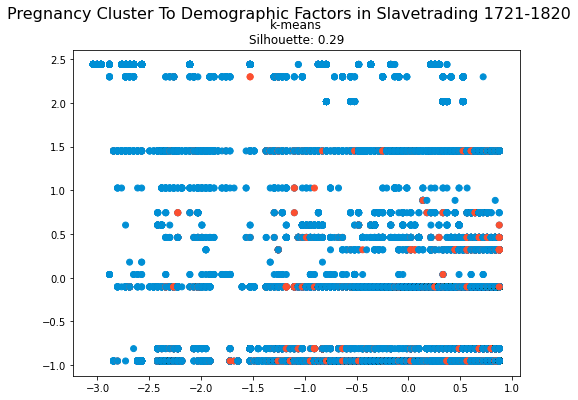

In [455]:
# Plot the data and cluster silhouette comparison
fig, (ax1) = plt.subplots(
    1, figsize=(8, 6), sharex=True, sharey=True)

fig.suptitle(f"Pregnancy Cluster To Demographic Factors in Slavetrading 1721-1820", fontsize=16)
fte_colors = {
    0: "#008fd5",
    1: "#fc4f30",}
# The k-means plot
km_colors = [fte_colors[label] for label in kmeans.labels_]
ax1.scatter(scaled_number_col[:, 0], scaled_number_col[:, 1], c=km_colors)
ax1.set_title(
    f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12})

plt.show()

Let's take the mean and standard deviation of the years column.

In [3]:
df = pd.read_csv("out.csv")

c:\users\casti\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (77,82,89,93) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Here's something weird. If you run a simple Pearson's ranking between the year column and the df['DEAD'] column, there's a negative correlation. It's rather slight, but this indicates that as the years went on, slaves were less likely to be sold as part of an estate sale.

Similarly, there's an ever-so-slight correlation between listing a slave auction as part of an estate sale, and the sale of expert workers.

In [8]:
dead_expert_correlation = dead.corr(expert)
dead_expert_correlation

0.029109816867256937

There is practically no correlation between listing someone as an apprentice (i.e. not skilled) and estate sales.

In [27]:
dead_apprentice_correlation = dead.corr(apprentice)
dead_apprentice_correlation

-0.0008488751120648041

In [216]:
def count_items_statistical_significance(column, exclude_list):
    '''
    Method to count items specifically for statistical significance. The reason I'm not
    using in-built methods is because I want to exclude certain values.
    
    Column is just a string name for the DataFrame column, but exclude list has to be a list.
    '''
    if type(exclude_list) is not list:
        error_message = "The exclude list must be a list, and only one level"
        return error_message
    counter = 0
    for index, value in df[column.upper()].items():
        if value not in exclude_list:
            counter += 1
    return counter

In [220]:
# How many experts are there in the dataset?
print(count_items_statistical_significance('EXPERT',[-1,0]))

# How many apprentices are there in the dataset?
print(count_items_statistical_significance('apprentice',[-1,0]))

df['APPRENTICE'].median()

1191
26


0.0

How are there 1191 experts but only 26 apprentices? Isn't an apprentice a step in the journey to being an expert? Is this price-gouging? Is this industry specific? 

In [187]:
def count_column1_with_respect_to_column2(col1, col2_value, col2):
    '''
        Counts how many entries in column 1 have a specific entry in column 2 and returns a 
    list with the count and the indices. However, this one just pulls all values that are 
    NOT in a certain range.
    
    Requires a list as col2_value.
    '''
    positives = []

    if col1 == col2:
        for index, value in df[col1.upper()].items():
            if df[col1.upper()].iloc[index] in col2_value:
                positives.append(index)
    for index, value in df[col1.upper()].items():
        if df[col2.upper()].iloc[index] in col2_value:
            positives.append(index)

    return [len(positives), positives]

In [201]:
def clump_yparam(dist_list, y_param, x_param = 'YEAR'):
    '''
    It is helpful to figure out what year a specific column tends to clump by.
    '''
    dict_returned = {}
    for entries in dist_list[1]:
        year = str(df[x_param.upper()].iloc[entries])
        if year in dict_returned and df[y_param].iloc[entries] > 0:
            dict_returned[year] += 1

        elif df[y_param].iloc[entries] > 0 and year not in dict_returned:
            dict_returned[year] = 1
    return dict_returned

def clump_filtered_yparam(dist_list, y_param, x_param = 'YEAR'):
    
    '''
    Instead of giving a total persons for the year, this one returns the average value
    '''
    dict_returned = {}
    for entries in dist_list[1]:
        year = str(df[x_param.upper()].iloc[entries])
        if year in dict_returned and df[y_param].iloc[entries] > 0:
            dict_returned[year].append(float(df[y_param.upper()].iloc[entries]))

        elif df[y_param].iloc[entries] > 0 and year not in dict_returned:
            dict_returned[year] = [float(df[y_param.upper()].iloc[entries])]
    for years in dict_returned:
        dict_returned[years] = statistics.mean(dict_returned[years])
    return dict_returned

Why does the sale of experts increase so much in the 1810s? Is it significant that this is after the law banning importation of slaves? The standard deviation is nearly thirty.

So something changed in the early 19th century. Can we find that exact pivot? I want to plot the years on the y axis and the number of expert slaves sold on the x axis.

So apprentices seem to have sold at a spiky but consistent rate, with a tiny uptick in the 1810s. But experts sold exponentially more often after 1790, and especially after 1800. Why were so many experts being sold but not apprentices?

In [202]:
def plot_col1_against_col2_by_year(y_param, xlabel, ylabel, filter_values, x_param = 'YEAR', filter_param = 'YEAR'):
    '''
    Plots the frequency of col2's sale against years (default) or any other column (optional)
    Col2: string
    Col2_values: list
    xlabel, ylabel, col1: strings
    '''

    # Figure out how often col2 occurs and how it is distributed across col3's values
    if filter_param == 'YEAR':
        distribution_list = count_column1_with_respect_to_column2(y_param.upper(), filter_values, y_param)
        frequency_dict = clump_yparam(distribution_list, y_param.upper(), x_param.upper())
    else:
        distribution_list = count_column1_with_respect_to_column2(y_param.upper(), filter_values, filter_param.upper())
        frequency_dict = clump_filtered_yparam(distribution_list, y_param.upper(), x_param.upper())
    # Change into a frequency calculation

    x_axis = []
    y_axis = []
    for year, total_count in frequency_dict.items():
        x_axis.append(year)
        y_axis.append(total_count)

    # Plot a line graph 
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(xlabel + ' vs ' + ylabel)

    plt.plot(x_axis, y_axis)

    plt.show()
    
    print("Correlation between ",filter_param," and ",y_param,": ",df[filter_param.upper()].corr(df[y_param.upper()]))
    print("Standard deviation between", y_param," filtered on", filter_param,": ",statistics.pstdev(y_axis))
    print("Median value of",y_param,"filtered on", filter_param,filter_values,": ", statistics.median(y_axis))

    

{'1724': 3200.0, '1730': 6901.333333333333, '1731': 188.46153846153845, '1735': 335.0, '1736': 415.2, '1737': 258.0689655172414, '1738': 1272.6545454545455, '1739': 604.4444444444445, '1740': 546.2765957446809, '1744': 806.25, '1745': 422.85714285714283, '1746': 671.0344827586207, '1747': 575.0, '1748': 496.0, '1753': 200.0, '1755': 302.85714285714283, '1757': 300.0, '1758': 532.8571428571429, '1759': 685.0, '1761': 565.0, '1762': 700.0, '1763': 323.3333333333333, '1764': 759.2222222222222, '1765': 762.25, '1766': 364.54545454545456, '1767': 373.3333333333333, '1768': 579.72, '1769': 401.7938144329897, '1770': 325.3488372093023, '1771': 465.53846153846155, '1772': 287.7916666666667, '1773': 285.3176470588235, '1774': 505.27027027027026, '1775': 529.3404255319149, '1776': 507.76, '1777': 464.06976744186045, '1778': 407.9024390243902, '1779': 475.05288461538464, '1780': 374.2857142857143, '1781': 485.8333333333333, '1782': 443.4488188976378, '1783': 295.0, '1784': 485.6756756756757, '178

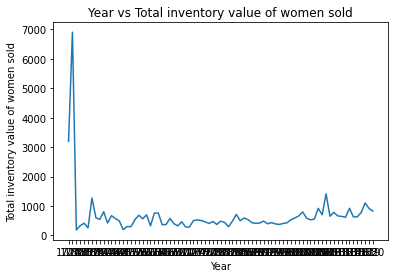

Correlation between  SEX  and  INVVALP :  -0.07218370252935037
Standard deviation between INVVALP  filtered on SEX :  795.7158289124528
Median value of INVVALP filtered on SEX [1] :  531.0357142857143
{'1725': 245.5, '1726': 1430.0, '1727': 310.0, '1728': 1400.857142857143, '1729': 260.0, '1731': 542.8571428571429, '1734': 744.2857142857143, '1735': 244.58823529411765, '1736': 298.72727272727275, '1737': 280.5, '1738': 377.5, '1739': 685.8, '1740': 654.5348837209302, '1741': 3963.3333333333335, '1743': 410.0, '1744': 1037.857142857143, '1745': 595.0555555555555, '1746': 1884.4814814814815, '1747': 507.23809523809524, '1748': 398.57142857142856, '1753': 690.0, '1756': 120.0, '1758': 594.2229299363057, '1759': 455.85714285714283, '1760': 620.0, '1762': 1903.4285714285713, '1763': 3944.705882352941, '1764': 3168.3793103448274, '1765': 772.9876543209876, '1766': 805.3947368421053, '1767': 1180.0, '1768': 377.6, '1769': 332.64406779661016, '1770': 945.8484848484849, '1771': 450.928571428571

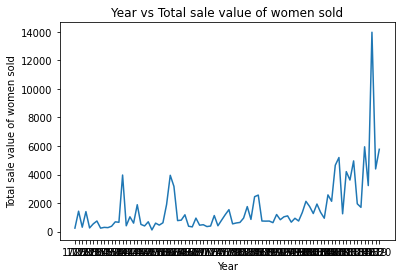

Correlation between  SEX  and  SALEVALP :  -0.03923141264196137
Standard deviation between SALEVALP  filtered on SEX :  1929.0695824423997
Median value of SALEVALP filtered on SEX [1] :  937.4624135334807
{'1738': 220.0, '1764': 700.0, '1779': 300.0, '1782': 550.0, '1785': 1000.0, '1789': 500.0, '1792': 350.0, '1797': 375.0, '1799': 800.0, '1803': 600.0, '1808': 800.0, '1809': 200.0, '1814': 825.0, '1816': 800.0, '1819': 1200.0, '1820': 1200.0}


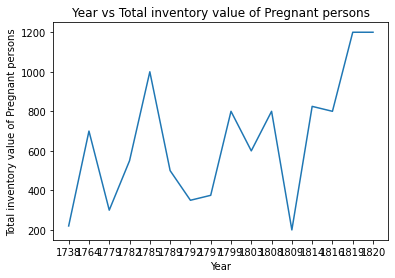

Correlation between  PREGNANT  and  INVVALP :  0.0020025503622775245
Standard deviation between INVVALP  filtered on PREGNANT :  310.1033093986583
Median value of INVVALP filtered on PREGNANT [1] :  650.0


In [203]:
# Women = 1 on SEX category
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Total inventory value of women sold',[1],'YEAR','SEX')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'Total sale value of women sold',[1],'YEAR', 'SEX')

plot_col1_against_col2_by_year('INVVALP', 'Year', 'Total inventory value of Pregnant persons',[1],'YEAR','PREGNANT')

{'1721': 826, '1723': 118, '1724': 24, '1725': 20, '1726': 168, '1727': 30, '1728': 124, '1729': 8, '1730': 66, '1731': 162, '1733': 2, '1734': 14, '1735': 158, '1736': 102, '1737': 134, '1738': 334, '1739': 260, '1740': 166, '1741': 28, '1742': 4, '1743': 22, '1744': 98, '1745': 130, '1746': 198, '1747': 216, '1748': 114, '1749': 24, '1750': 4, '1751': 8, '1752': 12, '1753': 84, '1754': 4, '1755': 36, '1756': 8, '1757': 2, '1758': 372, '1759': 40, '1760': 106, '1761': 10, '1762': 156, '1763': 134, '1764': 292, '1765': 382, '1766': 134, '1767': 118, '1768': 112, '1769': 350, '1770': 328, '1771': 342, '1772': 212, '1773': 336, '1774': 312, '1775': 304, '1776': 408, '1777': 696, '1778': 404, '1779': 622, '1780': 610, '1781': 408, '1782': 392, '1783': 542, '1784': 486, '1785': 476, '1786': 356, '1787': 518, '1788': 672, '1789': 718, '1790': 1134, '1791': 784, '1792': 878, '1793': 1034, '1794': 1086, '1795': 762, '1796': 756, '1797': 732, '1798': 796, '1799': 632, '1800': 1184, '1801': 674

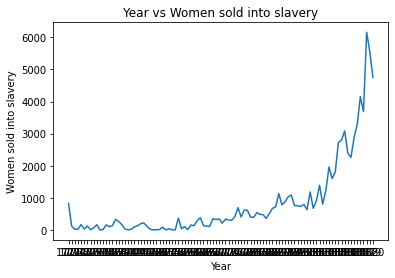

Correlation between  YEAR  and  SEX :  -0.39543197793481294
Standard deviation between SEX  filtered on YEAR :  1211.480870343673
Median value of SEX filtered on YEAR [1] :  346.0
{'1721': 1430, '1723': 248, '1724': 46, '1725': 40, '1726': 288, '1727': 56, '1728': 676, '1729': 28, '1730': 120, '1731': 526, '1733': 10, '1734': 44, '1735': 320, '1736': 178, '1737': 182, '1738': 480, '1739': 476, '1740': 282, '1741': 48, '1742': 20, '1743': 40, '1744': 160, '1745': 220, '1746': 262, '1747': 278, '1748': 188, '1749': 58, '1750': 8, '1751': 22, '1752': 32, '1753': 146, '1754': 2, '1755': 52, '1756': 10, '1757': 8, '1758': 586, '1759': 34, '1760': 148, '1761': 16, '1762': 218, '1763': 162, '1764': 510, '1765': 480, '1766': 244, '1767': 136, '1768': 160, '1769': 408, '1770': 396, '1771': 496, '1772': 292, '1773': 362, '1774': 390, '1775': 370, '1776': 520, '1777': 968, '1778': 554, '1779': 698, '1780': 742, '1781': 588, '1782': 590, '1783': 774, '1784': 758, '1785': 710, '1786': 702, '1787': 

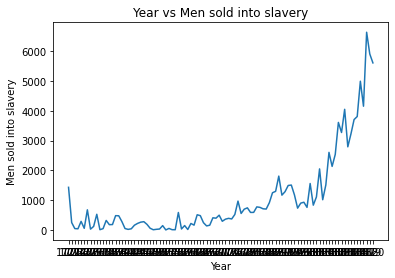

Correlation between  YEAR  and  SEX :  -0.39543197793481294
Standard deviation between SEX  filtered on YEAR :  1399.7931161472854
Median value of SEX filtered on YEAR [2] :  515.0
{'1727': 4, '1764': 2, '1765': 4, '1766': 2, '1769': 2, '1784': 2, '1787': 4, '1790': 2, '1793': 4, '1805': 2, '1806': 2, '1809': 4, '1810': 4, '1811': 2, '1812': 6, '1815': 4, '1818': 2}


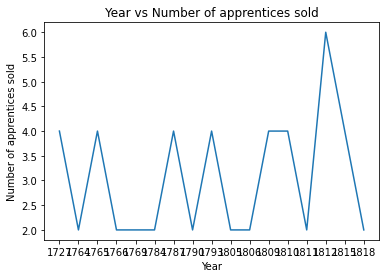

Correlation between  YEAR  and  APPRENTICE :  -0.004098548894959832
Standard deviation between APPRENTICE  filtered on YEAR :  1.211250604822
Median value of APPRENTICE filtered on YEAR [1] :  2


In [204]:
plot_col1_against_col2_by_year('SEX','Year','Women sold into slavery',[1] )
plot_col1_against_col2_by_year('SEX','Year','Men sold into slavery',[2])
plot_col1_against_col2_by_year('APPRENTICE','Year','Number of apprentices sold',[1])

In [ ]:
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of expert slaves',[-1,0],'YEAR','EXPERT')

plot_col1_against_col2_by_year('INVVALP', 'Year','Inventory value of non-expert slaves',[1],'YEAR', 'EXPERT')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'Sale value of expert slaves', [-1,0], 'YEAR', 'EXPERT')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'Sale value of non-expert slaves', [1], 'YEAR', 'EXPERT')


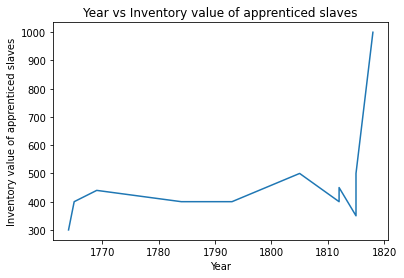

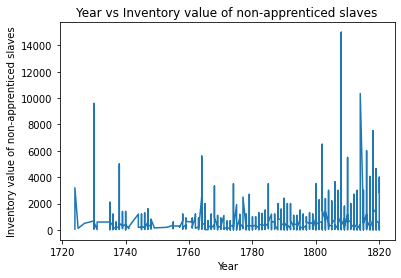

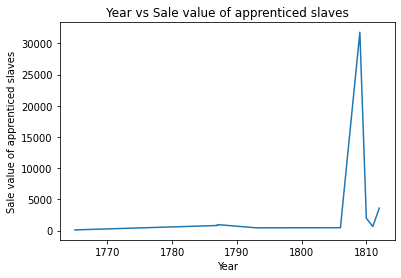

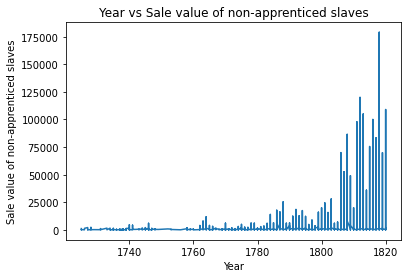

In [409]:
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of apprenticed slaves',[-1,0],'YEAR','APPRENTICE')
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of non-apprenticed slaves',[1],'YEAR', 'APPRENTICE')
plot_col1_against_col2_by_year('SALEVALP','Year', 'Sale value of apprenticed slaves',[-1,0],'YEAR','APPRENTICE')
plot_col1_against_col2_by_year('SALEVALP','Year', 'Sale value of non-apprenticed slaves',[1],'YEAR', 'APPRENTICE')

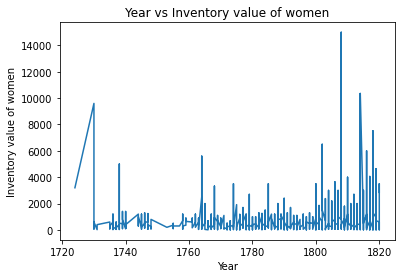

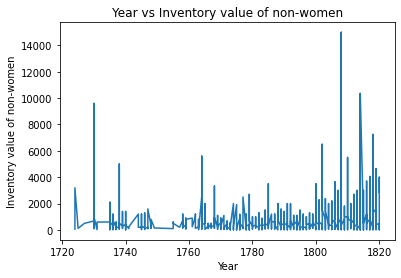

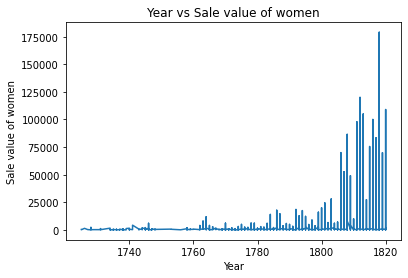

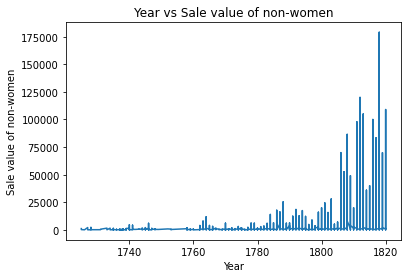

In [410]:
# Women = 1 on SEX category
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of women',[-1,0,2,9],'YEAR','SEX')
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of non-women',[1],'YEAR', 'SEX')
plot_col1_against_col2_by_year('SALEVALP','Year', 'Sale value of women',[-1,0,2,9],'YEAR','SEX')
plot_col1_against_col2_by_year('SALEVALP','Year', 'Sale value of non-women',[1],'YEAR', 'SEX')

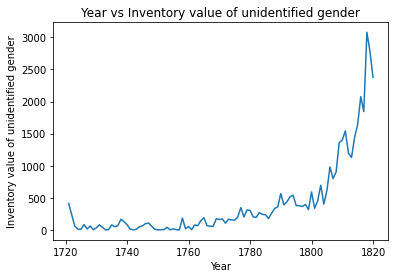

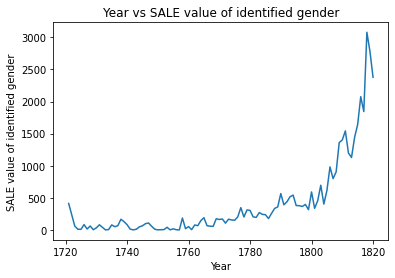

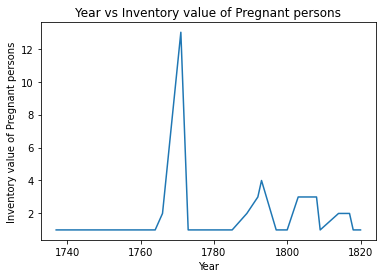

In [342]:
# Women = 1 on SEX category
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of unidentified gender',[-1,0,2,9],'YEAR','SEX')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'SALE value of identified gender',[-1,0,2,9],'YEAR', 'SEX')

plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of Pregnant persons',[-1,0,2,9],'YEAR','PREGNANT')


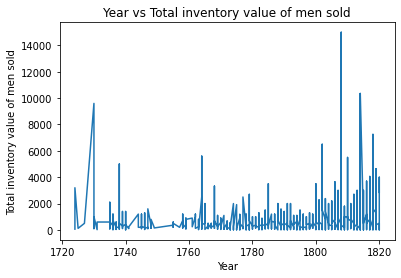

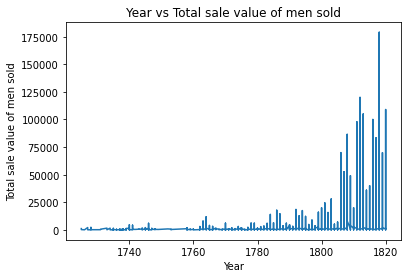

In [411]:
# Men = 2 on SEX category
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Total inventory value of men sold',[-1,0,1,9],'YEAR','SEX')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'Total sale value of men sold',[-1,0,1,9],'YEAR', 'SEX')